## //TODO: Get Y Labels
#### You should probably do this in API.py, so that there can be a different method you call from this cell which chooses tickers, calls getSamples to retrieve the requested X data, selects the samples we want from the X data, and then calculates Y using the <date> in X

In [ ]:
import requests
import pandas as pd
import random
from datetime import datetime
from dateutil.relativedelta import relativedelta
import sys

import time

class API:
    def __init__(self, key, period='annual', limit=5):
        self.base_url = 'https://financialmodelingprep.com/'
        self.params = {
            'apikey': key,
            'period': period,
            'limit': limit,
        }
        self.alwaysCols = ["symbol", "date"]

        # keeps tracks of the time each api call was made (so that we know whether we go over the api call limit)
        self.apiCalls = []

        if limit == None:
            del self.params['limit']

    def overApiCallLimit(self):
        API_CALL_LIMIT = 299 # call limit per minute
        calls = self.apiCalls
        length = len(calls)
        if length < API_CALL_LIMIT:
            return False

        lastTimeIndex = length - API_CALL_LIMIT
        lastTime = calls[lastTimeIndex]

        oneMinuteAgo = datetime.now() - relativedelta(seconds = 65) # datetime.now()
        # if the last time is more recent than one minute ago
        return lastTime >= oneMinuteAgo

    def waitForMoreApiCalls(self):
        if self.overApiCallLimit():
            print("Waiting for more API calls to be available...")
            time.sleep(65)

    def getNumApiCalls(self):
        return len(self.apiCalls)

    def request(self, url):
        print("Making API call request...")
        self.waitForMoreApiCalls()
        r = requests.get(url, params=self.params)

        if r.status_code != 200:
            raise Exception('API did not return a valid response')
        else:
            self.apiCalls.append(datetime.now())

        return r

    def getDataFrameUnordered(self, endpoint): # makes api calls (helper method)
        r = self.request(endpoint)

        print("Request result: ")
        print(r)

        try:
            df = pd.json_normalize(r.json())
        except ValueError:
            raise Exception("Bad URL or API Key!")

        return df

    def getDataFrame(self, endpoint): # makes api calls (helper method)
        df = self.getDataFrameUnordered(endpoint)

        if df.empty:
            raise ValueError("Error, empty dataframe")

        # df = df.reindex(index=df.index[::-1])
        df.sort_values(by=['date'], inplace=True, ascending=True)
        df.reset_index(drop=True, inplace=True)
        return df

    def getRatios(self, ticker):
        endpoint = self.base_url + 'api/v3/ratios/' + ticker
        wantedCols = [
            "currentRatio", "quickRatio", "grossProfitMargin", "operatingProfitMargin", "returnOnAssets",
            "returnOnEquity", "returnOnCapitalEmployed", "debtEquityRatio", "priceToBookRatio", "priceToSalesRatio",
            "priceEarningsRatio", "priceEarningsToGrowthRatio", "priceToOperatingCashFlowsRatio"
        ]
        df = self.getDataFrame(endpoint)
        df = df[self.alwaysCols + wantedCols]
        return df

    def getGrowths(self, ticker): # makes api call
        endpoint = self.base_url + 'api/v3/income-statement-growth/' + ticker
        wantedCols = [
            "growthRevenue", "growthCostOfRevenue", "growthGrossProfit", "growthGrossProfitRatio",
            "growthOperatingExpenses", "growthEBITDA", "growthOperatingIncome", "growthNetIncome",
            "growthEPS"
        ]
        df = self.getDataFrame(endpoint)
        df = df[self.alwaysCols + wantedCols]
        return df

    def getValues(self, ticker): # makes API call
        endpoint = self.base_url + 'api/v3/enterprise-values/' + ticker
        wantedCols = [
            "marketCapitalization", "enterpriseValue"
        ]
        df = self.getDataFrame(endpoint)
        df = df[self.alwaysCols + wantedCols]
        return df

    def getFinStat(self, ticker, limit): # makes API call
        self.params['limit'] = limit
        self.params['period'] = 'quarter'
        endpoint = self.base_url + 'api/v3/income-statement/' + ticker
        return self.getDataFrame(endpoint)

    def getSamples(self, ticker): # makes API calls
        ratios = self.getRatios(ticker)
        growths = self.getGrowths(ticker)
        values = self.getValues(ticker)

        merge = pd.merge(ratios, growths, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"])
        merge = pd.merge(merge, values, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"])

        return merge

    def getRandTickers(self, num): # makes api calls
        endpoint = self.base_url + 'api/v3/available-traded/list'
        tickers = pd.DataFrame(self.request(endpoint).json())
        rowIdx = random.sample(range(0, len(tickers)), num)

        return list(tickers.iloc[rowIdx]['symbol'])

    def getSamplesFromTickers(self, tickers, samplesPerTicker=5, maxTickers=10): # makes API calls
        '''
        tickers: list Creates dataframe of samples from list of tickers
        samplesPerTicker: int Number of rows of data to get per ticker
        '''
        result = pd.DataFrame()
        i = 0

        for t in tickers:
            if i >= maxTickers:
                break

            try:
                oneYearAgo = (datetime.today() - relativedelta(years=1, months=6)).strftime('%Y-%m-%d')
                df = self.getSamples(t)
                df = df[df['date'] < oneYearAgo]
                rowIdx = random.sample(range(0, len(df)), samplesPerTicker)
            except ValueError:
                # Ticker didn't have enough data
                continue

            samples = df.iloc[rowIdx]
            result = result.append(pd.DataFrame(samples))
            i += 1

        return result

    def getYFromDF(self, X):
        groups = X.groupby(['symbol'])
        result = pd.DataFrame()

        for state, frame in groups:
            dates = list(frame['date'])
            try:
                priceChange = self.getPriceChange(state, dates)
            except ValueError:
                # No price data for stock
                print("Ticker {} didn't have price data".format(state))
                continue

            result = result.append(priceChange)

        return result

    def getPriceChange(self, ticker, dates):

        #Currently returns price in dollars instead of percentage

        endpoint = self.base_url + 'api/v3/historical-price-full/' + ticker
        self.params['serietype'] = 'line'
        r = self.request(endpoint)
        del self.params['serietype']

        if not r.json():
            raise ValueError("No price data for stock")

        addOneYear = lambda d: (datetime.strptime(d, "%Y-%m-%d") + relativedelta(years=1)).strftime('%Y-%m-%d')
        subOneYear = lambda d: (datetime.strptime(d, "%Y-%m-%d") - relativedelta(years=1)).strftime('%Y-%m-%d')

        futureDates = [addOneYear(d) for d in dates]

        priceDataPresent = [o for o in r.json()['historical'] if o['date'] in dates]
        priceDataFuture = [o for o in r.json()['historical'] if o['date'] in futureDates]

        combinedPriceData = {}
        for o in (priceDataPresent + priceDataFuture):
            try:
                combinedPriceData[o['date']] = o['close']
            except Exception as e:
                print("Bad object was:")
                print(o)
                print('From:')
                print(priceDataPresent + priceDataFuture)
                print(e)
                continue

        endData = {'symbol': [], 'date': [], 'futureDate': [], 'futureClose': [], 'percentage': []}

        for i, date in enumerate(dates):

            futureDate = addOneYear(date)

            if date not in combinedPriceData or futureDate not in combinedPriceData:
                print('Date {} not found for {}'.format(date, ticker))
                continue

            endData['date'].append(date)
            endData['futureDate'].append(futureDate)
            endData['futureClose'].append(combinedPriceData[futureDate])
            endData['symbol'].append(ticker)

            percentageChange = (combinedPriceData[futureDate] - combinedPriceData[date]) / combinedPriceData[date]
            endData['percentage'].append(percentageChange)

        return pd.DataFrame(endData)

In [ ]:
import os
import requests
import numpy as np
import pandas as pd
import imp

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler

import statsmodels.tsa.api as tsa
from scipy import stats
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

api_key = 'b903b84d1ce1092d3e9fca34e25bf408'
#from api_keys import fmp_api_key as api_key
# from API import API
#import API
#imp.reload(API)
#from API import API


api = API(api_key, period='quarter', limit=None)
tickers = api.getRandTickers(50)
tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']

X = api.getSamplesFromTickers(tickers, samplesPerTicker=100, maxTickers=50)
Y = api.getYFromDF(X)


Making API call request...
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200

In [ ]:
print(api.getNumApiCalls())

29


## Format X and Y Data

In [ ]:
print(tickers)

baselinePercentage = .06
Y['baselinePercentage'] = Y.apply(lambda row: baselinePercentage, axis=1)

merged = pd.merge(X, Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()

display(merged)

['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']


,symbol,date,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceEarningsToGrowthRatio,priceToOperatingCashFlowsRatio,growthRevenue,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue,futureDate,futureClose,percentage,baselinePercentage
0,AAPL,1993-03-31,2.486968,1.256414,0.406252,0.085668,0.024809,0.048508,0.056355,0.955253,2.715416,3.145034,13.994552,0.581428,-117.575442,0.149466,0.261380,0.026313,-0.107139,-0.028530,0.084785,0.197414,0.224753,0.240693,6.207983e+09,5.707283e+09,1994-03-31,0.296875,-0.354368,0.06
1,AAPL,1991-12-31,2.417060,1.183192,0.463331,0.140986,0.044320,0.086332,0.106114,0.947941,3.578668,3.694332,10.363047,-0.663154,22.509203,-0.046434,0.006513,-0.091210,-0.046956,-0.060347,-0.156080,-0.183012,-0.128904,-0.156269,6.881063e+09,6.396663e+09,1992-12-31,0.533482,0.059867,0.06
2,AAPL,1992-03-31,2.603645,1.311136,0.469580,0.122611,0.034282,0.064734,0.078216,0.888309,3.427961,4.169088,13.238629,-0.094061,22.266278,-0.043250,0.002847,-0.086424,-0.045126,0.319706,-1.151828,-1.475884,-1.405034,-1.407446,7.154155e+09,6.523655e+09,1993-03-31,0.459821,-0.115880,0.06
3,AAPL,1993-06-30,1.869350,0.790864,0.347691,-0.164715,-0.039492,-0.093195,-0.114835,1.359812,2.244632,2.435703,-6.021349,0.192105,-15.747500,-0.013198,0.019130,-0.056921,-0.044308,0.038228,-0.243754,-0.297757,-0.312461,-0.313440,4.535280e+09,4.450280e+09,1994-06-30,0.236607,-0.329115,0.06
4,AAPL,1992-06-30,2.521323,1.243205,0.476095,0.115561,0.031957,0.062082,0.072770,0.942679,2.759181,3.363595,11.111100,0.027162,24.844344,0.218501,0.289973,0.145018,-0.060306,-0.287359,-9.849858,-3.957207,-4.126177,-4.090608,5.853327e+09,5.302227e+09,1993-06-30,0.352679,-0.177082,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,JPM,2007-12-31,1.234261,0.062348,0.000000,0.000000,0.001902,0.024111,0.000000,11.563857,1.203004,8.527117,12.473528,-0.996708,-5.068397,0.078947,0.000000,0.000000,0.000000,0.073745,0.000000,0.000000,-0.119182,-0.125147,1.482354e+11,3.740664e+11,2008-12-31,31.530001,-0.277663,0.06
107,JPM,1997-06-30,0.000000,0.045387,0.000000,0.000000,0.002628,0.043340,0.000000,15.494073,1.920159,9.899021,11.076202,3.710528,150.668920,-0.002410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002157,0.029851,4.098195e+10,4.688395e+10,1998-06-30,50.333332,0.555699,0.06
108,JPM,2014-03-31,0.166884,0.397367,0.000000,0.000000,0.002129,0.024010,0.000000,10.276711,1.046737,9.999605,10.898792,-7.138709,15.676069,-0.007039,0.000000,0.000000,0.000000,-0.040688,0.000000,0.000000,-0.000758,-0.015267,2.299209e+11,1.664059e+11,2015-03-31,60.580002,-0.002141,0.06
109,JNJ,2001-12-31,2.296494,1.566634,0.703796,0.182078,0.028710,0.045599,0.050256,0.588247,7.418900,21.395001,40.674705,-1.487169,64.299783,0.020029,0.043606,0.010422,-0.009418,0.155813,-0.241490,-0.257282,-0.277305,-0.273504,1.797822e+11,1.788062e+11,2002-12-31,53.709999,-0.091201,0.06


In [ ]:
X = merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage', 'baselinePercentage'], axis=1)
Y = merged[['percentage']]
Y_baseline = merged[['baselinePercentage']]

In [ ]:
arrayTry = [[3, 2, 1, 20], [1, 1, 50, 3]]

npArray = np.array(arrayTry)

zTry = np.abs(stats.zscore(arrayTry, axis=1))
print(zTry)
threshold = 1.7 

#for col in arrayTry
XWithoutOutliers = npArray[zTry < threshold]
print(XWithoutOutliers)

[[0.4472136  0.57498891 0.70276422 1.72496673]
 [0.608741   0.608741   1.73073422 0.51325222]]
[3 2 1 1 1 3]


Removing Outliers to see if this improves normalization and accuracy of model 

In [ ]:


#Create additional set of X featurs without outliers: 
#print("X")
#print(X)
print("")
#XReduced = X[X.columns[2:]]
#print("X Reduced Shape")
#print(XReduced.shape)
#for colName in XReduced: 
  #print(colName)
#Get z score of dataframe 

print("")
#print("Z values")

#First try:
#z = np.abs(stats.zscore(XReduced, axis=1))

#print("Z scores shape")
#print(z.shape)
#print(z)

#XReducedWithoutOutliers = XReduced[(z < threshold).all(axis=0)]

#Second try:
mergedForOutliers = merged.drop(['date', 'symbol', 'futureDate', 'futureClose'], axis=1)

display(mergedForOutliers)


threshold = 3
z_scores = stats.zscore(mergedForOutliers)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < threshold).all(axis=1)
mergedWithoutOutliers = mergedForOutliers[filtered_entries]

display(mergedWithoutOutliers)

#print("Z values above threshold (outliers): ")
#outliers = np.where(z > 3)
#noOutliers = np.where(z < 3)


#print("X Normal")
#print(X.shape)
#display(X.head(5))
#Removing outliers: 
#XReducedWithoutOutliers = XReduced[(z < threshold).all(axis=1)]

#print("X without outliers: " )
#print(XWithoutOutliers.shape)
#display(XWithoutOutliers.head(5))

XWithoutOutliers = mergedWithoutOutliers.drop(['percentage', 'baselinePercentage'], axis=1)




,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceEarningsToGrowthRatio,priceToOperatingCashFlowsRatio,growthRevenue,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue,percentage,baselinePercentage
0,2.486968,1.256414,0.406252,0.085668,0.024809,0.048508,0.056355,0.955253,2.715416,3.145034,13.994552,0.581428,-117.575442,0.149466,0.261380,0.026313,-0.107139,-0.028530,0.084785,0.197414,0.224753,0.240693,6.207983e+09,5.707283e+09,-0.354368,0.06
1,2.417060,1.183192,0.463331,0.140986,0.044320,0.086332,0.106114,0.947941,3.578668,3.694332,10.363047,-0.663154,22.509203,-0.046434,0.006513,-0.091210,-0.046956,-0.060347,-0.156080,-0.183012,-0.128904,-0.156269,6.881063e+09,6.396663e+09,0.059867,0.06
2,2.603645,1.311136,0.469580,0.122611,0.034282,0.064734,0.078216,0.888309,3.427961,4.169088,13.238629,-0.094061,22.266278,-0.043250,0.002847,-0.086424,-0.045126,0.319706,-1.151828,-1.475884,-1.405034,-1.407446,7.154155e+09,6.523655e+09,-0.115880,0.06
3,1.869350,0.790864,0.347691,-0.164715,-0.039492,-0.093195,-0.114835,1.359812,2.244632,2.435703,-6.021349,0.192105,-15.747500,-0.013198,0.019130,-0.056921,-0.044308,0.038228,-0.243754,-0.297757,-0.312461,-0.313440,4.535280e+09,4.450280e+09,-0.329115,0.06
4,2.521323,1.243205,0.476095,0.115561,0.031957,0.062082,0.072770,0.942679,2.759181,3.363595,11.111100,0.027162,24.844344,0.218501,0.289973,0.145018,-0.060306,-0.287359,-9.849858,-3.957207,-4.126177,-4.090608,5.853327e+09,5.302227e+09,-0.177082,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1.234261,0.062348,0.000000,0.000000,0.001902,0.024111,0.000000,11.563857,1.203004,8.527117,12.473528,-0.996708,-5.068397,0.078947,0.000000,0.000000,0.000000,0.073745,0.000000,0.000000,-0.119182,-0.125147,1.482354e+11,3.740664e+11,-0.277663,0.06
107,0.000000,0.045387,0.000000,0.000000,0.002628,0.043340,0.000000,15.494073,1.920159,9.899021,11.076202,3.710528,150.668920,-0.002410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002157,0.029851,4.098195e+10,4.688395e+10,0.555699,0.06
108,0.166884,0.397367,0.000000,0.000000,0.002129,0.024010,0.000000,10.276711,1.046737,9.999605,10.898792,-7.138709,15.676069,-0.007039,0.000000,0.000000,0.000000,-0.040688,0.000000,0.000000,-0.000758,-0.015267,2.299209e+11,1.664059e+11,-0.002141,0.06
109,2.296494,1.566634,0.703796,0.182078,0.028710,0.045599,0.050256,0.588247,7.418900,21.395001,40.674705,-1.487169,64.299783,0.020029,0.043606,0.010422,-0.009418,0.155813,-0.241490,-0.257282,-0.277305,-0.273504,1.797822e+11,1.788062e+11,-0.091201,0.06


,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceEarningsToGrowthRatio,priceToOperatingCashFlowsRatio,growthRevenue,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue,percentage,baselinePercentage
1,2.417060,1.183192,0.463331,0.140986,0.044320,0.086332,0.106114,0.947941,3.578668,3.694332,10.363047,-0.663154,22.509203,-0.046434,0.006513,-0.091210,-0.046956,-0.060347,-0.156080,-0.183012,-0.128904,-0.156269,6.881063e+09,6.396663e+09,0.059867,0.06
5,2.372470,1.485405,0.541808,0.136318,0.047667,0.097405,0.109544,1.043428,3.272193,3.017526,8.398447,0.282528,22.282349,0.196443,0.000000,0.000000,0.000000,0.000000,-0.809486,-0.847781,0.000000,0.297260,5.055865e+09,4.339565e+09,0.311044,0.06
8,2.515752,2.283975,0.643421,0.301022,0.026760,0.050349,0.055889,0.881513,4.241141,16.483067,21.058571,-11.792800,45.777310,-0.007741,0.089269,-0.054412,-0.047035,-0.134452,0.007305,0.056741,-0.015611,-0.017857,3.824236e+11,3.998416e+11,-0.045298,0.06
9,2.063200,1.846919,0.810039,0.356685,0.047179,0.087639,0.088449,0.857580,5.617708,17.705677,16.025052,-0.414441,34.733591,-0.237567,-0.240628,-0.236846,0.000946,-0.044470,-0.219106,-0.392341,-0.398679,-0.386667,2.567854e+11,2.546254e+11,-0.133151,0.06
10,2.886982,2.676994,0.854574,0.346050,0.038672,0.054103,0.066399,0.399004,5.538799,27.275418,25.593984,-1.039647,52.446436,-0.110741,-0.272112,-0.075877,0.039206,0.179648,-0.256537,-0.299010,-0.259890,-0.246180,2.623895e+11,2.586075e+11,0.125776,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1.234261,0.062348,0.000000,0.000000,0.001902,0.024111,0.000000,11.563857,1.203004,8.527117,12.473528,-0.996708,-5.068397,0.078947,0.000000,0.000000,0.000000,0.073745,0.000000,0.000000,-0.119182,-0.125147,1.482354e+11,3.740664e+11,-0.277663,0.06
107,0.000000,0.045387,0.000000,0.000000,0.002628,0.043340,0.000000,15.494073,1.920159,9.899021,11.076202,3.710528,150.668920,-0.002410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002157,0.029851,4.098195e+10,4.688395e+10,0.555699,0.06
108,0.166884,0.397367,0.000000,0.000000,0.002129,0.024010,0.000000,10.276711,1.046737,9.999605,10.898792,-7.138709,15.676069,-0.007039,0.000000,0.000000,0.000000,-0.040688,0.000000,0.000000,-0.000758,-0.015267,2.299209e+11,1.664059e+11,-0.002141,0.06
109,2.296494,1.566634,0.703796,0.182078,0.028710,0.045599,0.050256,0.588247,7.418900,21.395001,40.674705,-1.487169,64.299783,0.020029,0.043606,0.010422,-0.009418,0.155813,-0.241490,-0.257282,-0.277305,-0.273504,1.797822e+11,1.788062e+11,-0.091201,0.06


Plot features without Outliers: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

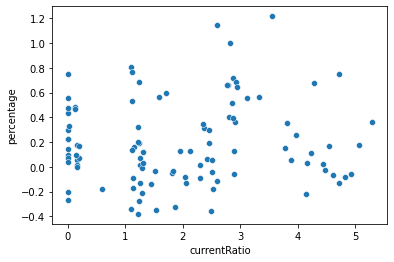

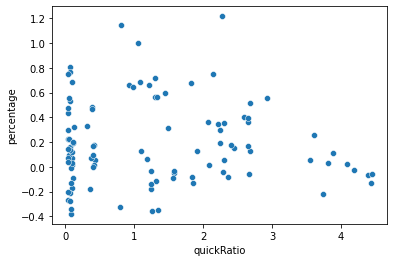

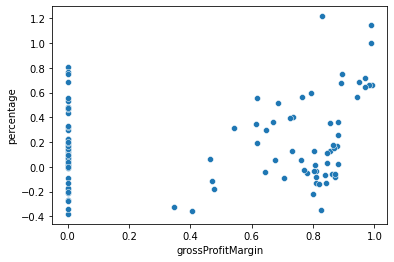

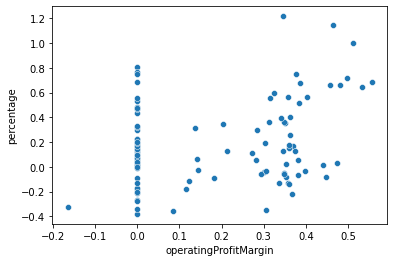

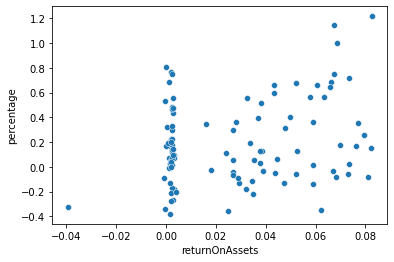

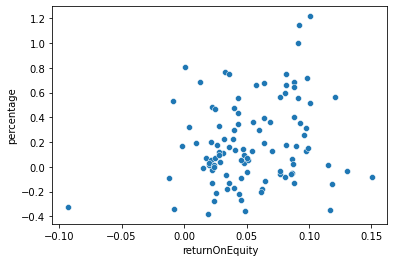

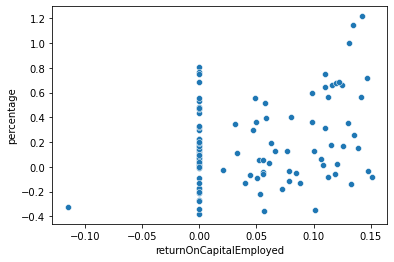

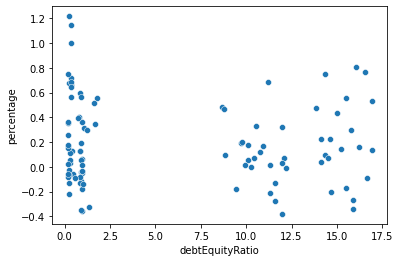

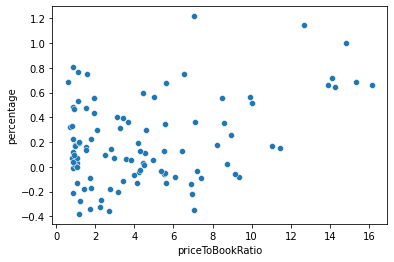

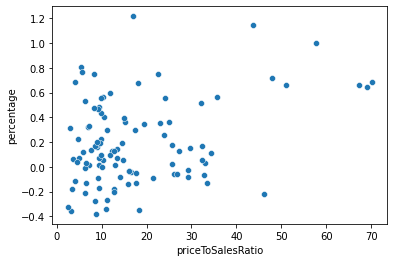

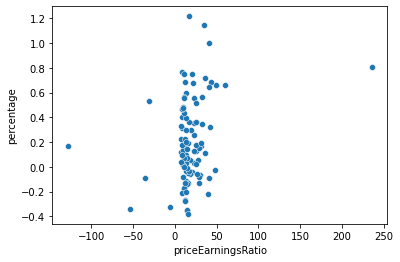

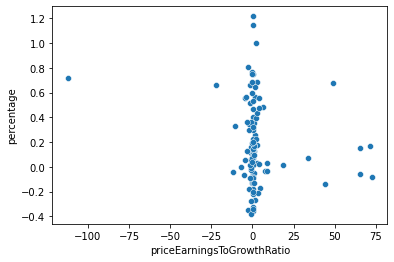

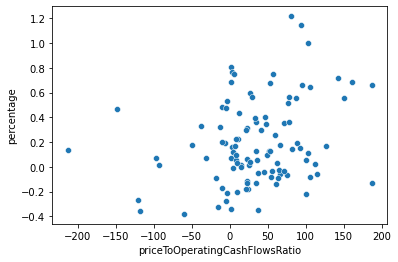

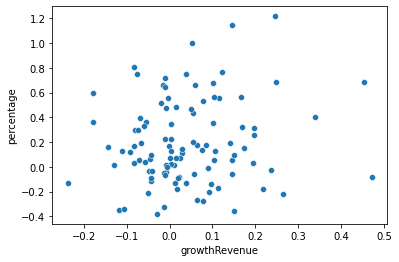

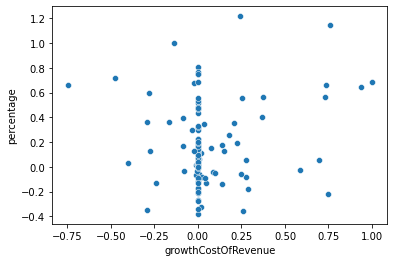

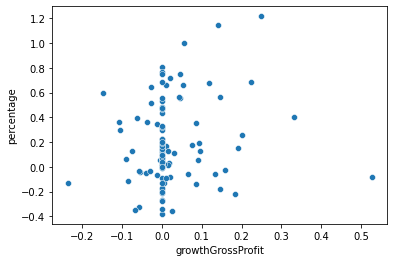

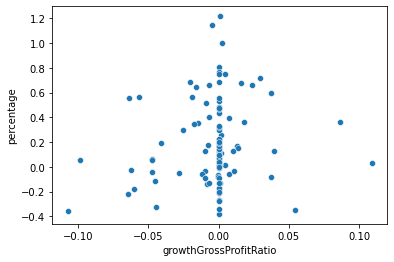

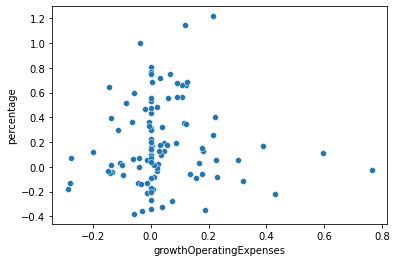

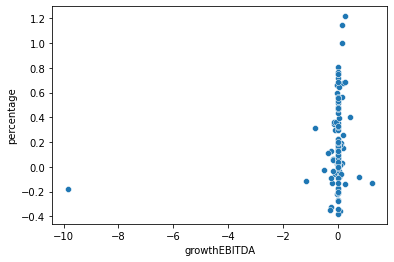

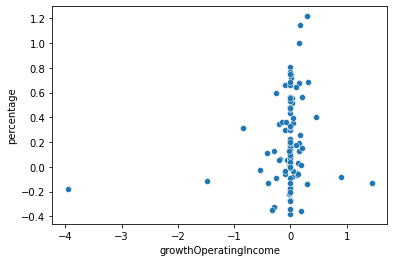

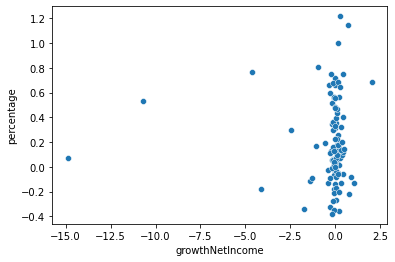

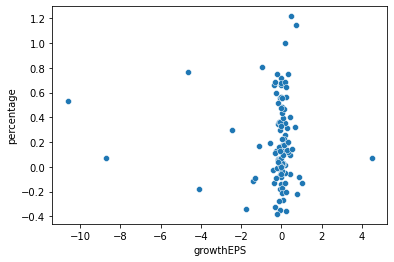

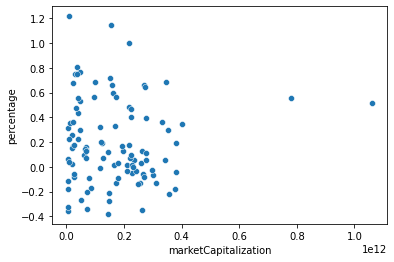

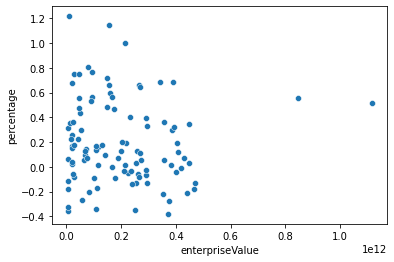

In [ ]:
for colName in XWithoutOutliers:
  plt.figure()
  sns.scatterplot(data=merged, x=colName, y='percentage')

## Plot Features to Examine Distributions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

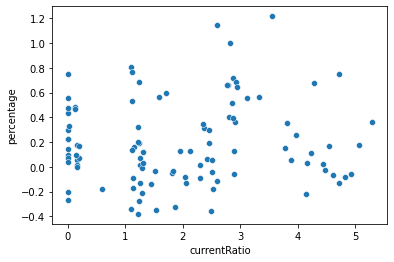

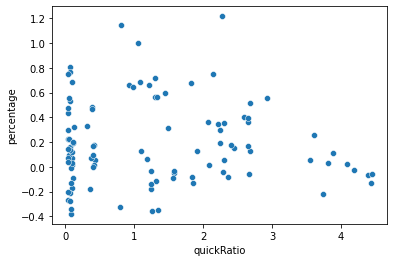

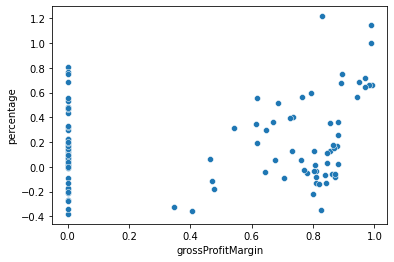

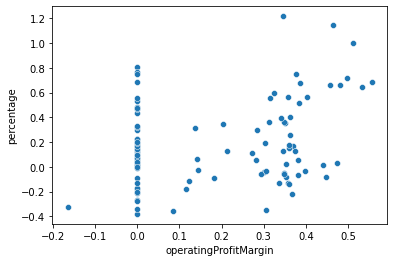

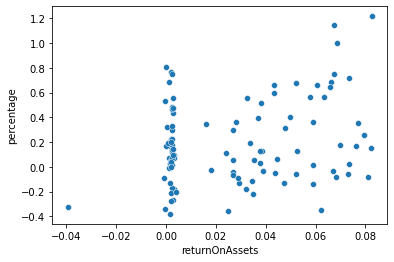

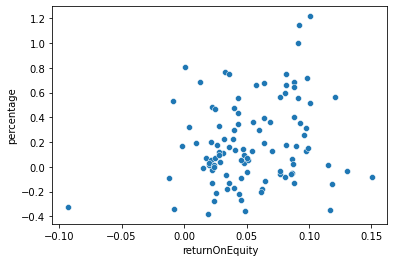

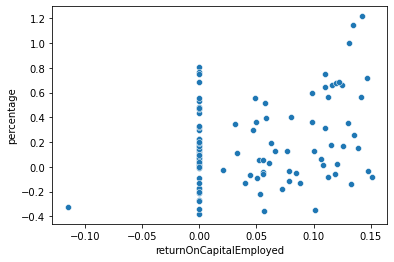

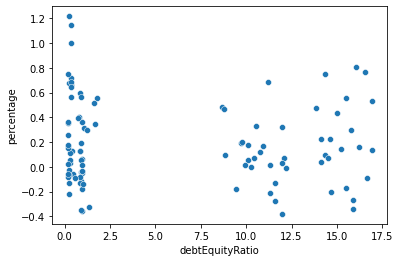

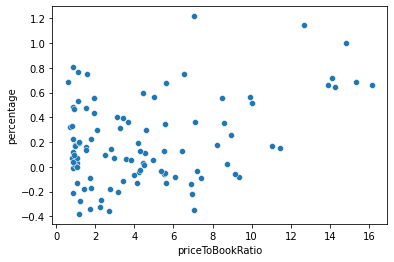

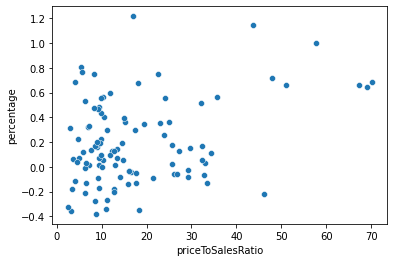

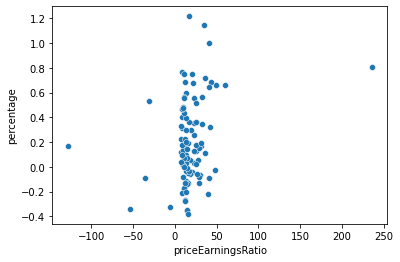

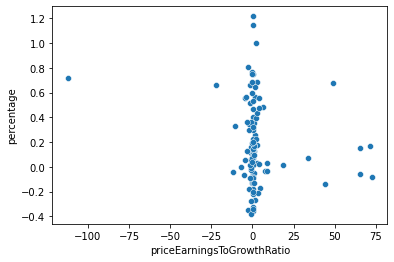

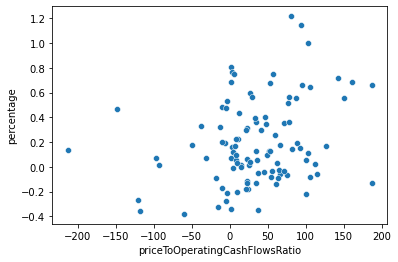

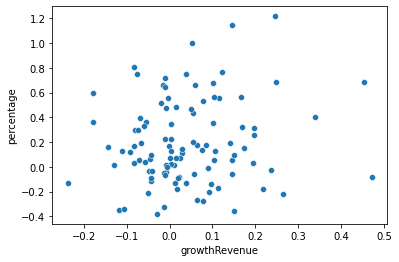

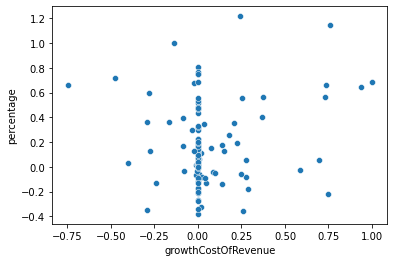

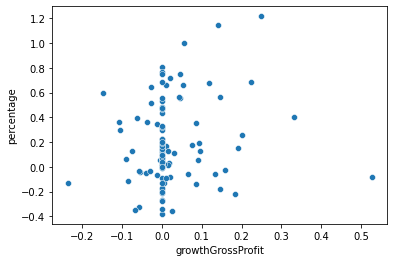

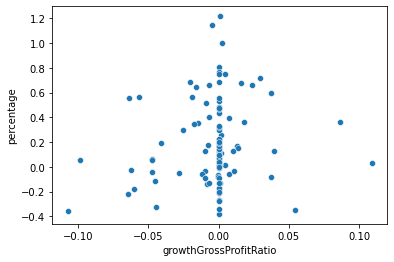

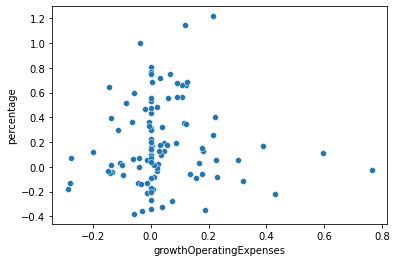

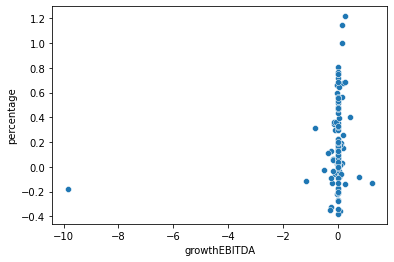

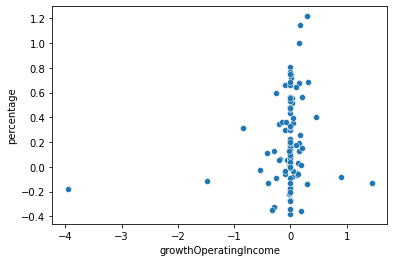

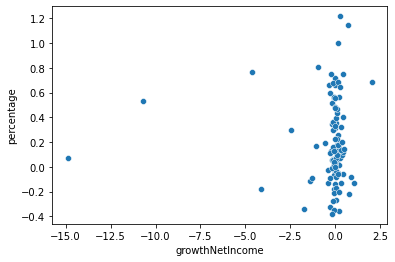

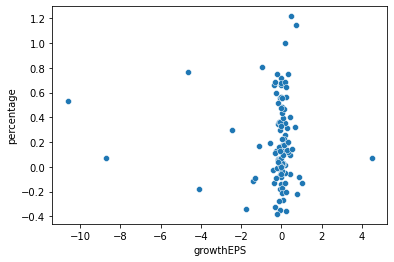

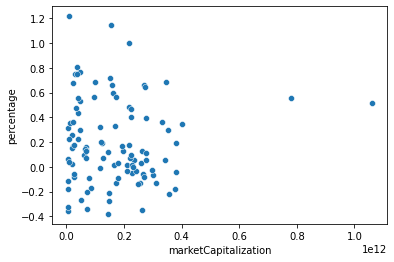

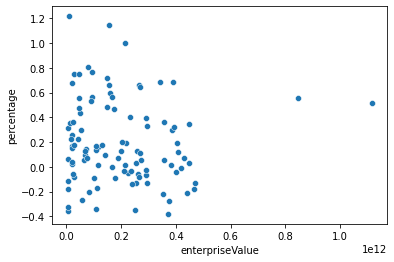

In [ ]:
# plt.figure()
for colName in X:
  plt.figure()
  sns.scatterplot(data=merged, x=colName, y='percentage')

In [ ]:
#In here split X and Y again 

#X = n - 1 columns 
#y = column 
#Comment out to see results with outliers, leave to see results without outliers 

X = mergedWithoutOutliers.drop(['percentage'], axis=1)
display(X)
Y = mergedWithoutOutliers[['percentage']]
Y_baseline = mergedWithoutOutliers[['baselinePercentage']]
#X = XWithoutOutliers

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceEarningsToGrowthRatio,priceToOperatingCashFlowsRatio,growthRevenue,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue,baselinePercentage
1,2.417060,1.183192,0.463331,0.140986,0.044320,0.086332,0.106114,0.947941,3.578668,3.694332,10.363047,-0.663154,22.509203,-0.046434,0.006513,-0.091210,-0.046956,-0.060347,-0.156080,-0.183012,-0.128904,-0.156269,6.881063e+09,6.396663e+09,0.06
5,2.372470,1.485405,0.541808,0.136318,0.047667,0.097405,0.109544,1.043428,3.272193,3.017526,8.398447,0.282528,22.282349,0.196443,0.000000,0.000000,0.000000,0.000000,-0.809486,-0.847781,0.000000,0.297260,5.055865e+09,4.339565e+09,0.06
8,2.515752,2.283975,0.643421,0.301022,0.026760,0.050349,0.055889,0.881513,4.241141,16.483067,21.058571,-11.792800,45.777310,-0.007741,0.089269,-0.054412,-0.047035,-0.134452,0.007305,0.056741,-0.015611,-0.017857,3.824236e+11,3.998416e+11,0.06
9,2.063200,1.846919,0.810039,0.356685,0.047179,0.087639,0.088449,0.857580,5.617708,17.705677,16.025052,-0.414441,34.733591,-0.237567,-0.240628,-0.236846,0.000946,-0.044470,-0.219106,-0.392341,-0.398679,-0.386667,2.567854e+11,2.546254e+11,0.06
10,2.886982,2.676994,0.854574,0.346050,0.038672,0.054103,0.066399,0.399004,5.538799,27.275418,25.593984,-1.039647,52.446436,-0.110741,-0.272112,-0.075877,0.039206,0.179648,-0.256537,-0.299010,-0.259890,-0.246180,2.623895e+11,2.586075e+11,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1.234261,0.062348,0.000000,0.000000,0.001902,0.024111,0.000000,11.563857,1.203004,8.527117,12.473528,-0.996708,-5.068397,0.078947,0.000000,0.000000,0.000000,0.073745,0.000000,0.000000,-0.119182,-0.125147,1.482354e+11,3.740664e+11,0.06
107,0.000000,0.045387,0.000000,0.000000,0.002628,0.043340,0.000000,15.494073,1.920159,9.899021,11.076202,3.710528,150.668920,-0.002410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002157,0.029851,4.098195e+10,4.688395e+10,0.06
108,0.166884,0.397367,0.000000,0.000000,0.002129,0.024010,0.000000,10.276711,1.046737,9.999605,10.898792,-7.138709,15.676069,-0.007039,0.000000,0.000000,0.000000,-0.040688,0.000000,0.000000,-0.000758,-0.015267,2.299209e+11,1.664059e+11,0.06
109,2.296494,1.566634,0.703796,0.182078,0.028710,0.045599,0.050256,0.588247,7.418900,21.395001,40.674705,-1.487169,64.299783,0.020029,0.043606,0.010422,-0.009418,0.155813,-0.241490,-0.257282,-0.277305,-0.273504,1.797822e+11,1.788062e+11,0.06


## Scaling/ Normalization

In [ ]:
# min_max_scaler = MinMaxScaler((-1, 1))
# df[percentages] = min_max_scaler.fit_transform(df[percentages])  # No need, because percentages are already on a good scale
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X), columns = X.columns)
display(X_scaled.head())



,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceEarningsToGrowthRatio,priceToOperatingCashFlowsRatio,growthRevenue,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue,baselinePercentage
0,0.549471,0.131484,0.239607,-0.075881,0.765473,1.062208,1.223411,-0.980256,-0.041952,-1.097053,-0.346985,-0.310141,-0.030230,-0.685507,-0.158072,-1.523467,-2.381259,-0.805995,-1.089314,-1.117766,-0.050277,-0.151833,-1.339505,-1.284204,0.0
1,0.518103,0.400122,0.435115,-0.102686,0.892825,1.406099,1.290169,-0.965043,-0.142773,-1.164960,-0.493431,-0.207741,-0.034722,1.859072,-0.194322,-0.112843,0.179891,-0.190081,-6.069736,-5.526535,0.135364,0.364610,-1.356234,-1.298521,0.0
2,0.618896,1.109973,0.688256,0.843041,0.097421,-0.055384,0.246020,-0.990839,0.175982,0.186089,0.450284,-1.515273,0.430544,-0.280128,0.302537,-0.954363,-2.385567,-1.562317,0.156043,0.472286,0.112882,0.005779,2.102623,1.454089,0.0
3,0.300544,0.721473,1.103346,1.162659,0.874262,1.102803,0.879638,-0.994652,0.628832,0.308758,0.075074,-0.283210,0.211847,-2.687977,-1.533625,-3.775838,0.231506,-0.643951,-1.569715,-2.506042,-0.438795,-0.414191,0.951055,0.443415,0.0
4,0.880042,1.459327,1.214293,1.101593,0.550612,0.061186,0.450556,-1.067712,0.602873,1.268926,0.788364,-0.350908,0.562611,-1.359246,-1.708860,-1.286335,2.318346,1.643431,-1.855023,-1.887069,-0.238918,-0.254216,1.002421,0.471129,0.0


## Reduce Dimensionality with PCA

In [ ]:
pca = PCA(n_components='mle')
X_pc = pca.fit_transform(X_scaled)
# print(pca.components_)
# print(pca.explained_variance_)
display(X_pc.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:74: RuntimeWarning: divide by zero encountered in log
  pv = -np.log(v) * n_samples * (n_features - rank) / 2.
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:85: RuntimeWarning: divide by zero encountered in double_scalars
  (1. / spectrum_[j] - 1. / spectrum_[i])) + log(n_samples)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:87: RuntimeWarning: invalid value encountered in double_scalars
  ll = pu + pl + pv + pp - pa / 2. - rank * log(n_samples) / 2.


(73, 24)

## Examine Distribution on 1st Principle Component

In [ ]:
# plt.scatter(X_pc[:,0], Y)
print(X_pc[:,0].shape)
print(Y.shape)
print(Y)

(73,)
(73, 1)
     percentage
1      0.059867
5      0.311044
8     -0.045298
9     -0.133151
10     0.125776
..          ...
106   -0.277663
107    0.555699
108   -0.002141
109   -0.091201
110    0.125610

[73 rows x 1 columns]


## Transform Data to Polynomial Features, Train Models, and Plot Error

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def trainAndGetResults(X, baseline=False):
    results = {'clf': [] , 'x': [], 'X_train': [], 'Y_pred': [], 'Y_test': [], 'mse': [], 'rmse': []}
    for i in range(1, 5):
        if not baseline:
            print("X Shape = ")
            print(X.shape)
            poly = PolynomialFeatures(degree=i)
            poly_features = poly.fit_transform(X)
            X_train, X_test, Y_train, Y_test = train_test_split(poly_features, Y, test_size=0.33, random_state=42)

            clf = LinearRegression()
            print("Poly Shape = ")
            print(poly_features.shape)
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test)
            results['clf'].append(clf)
            results['X_train'].append(X_train)
            results['Y_pred'].append(Y_pred)
            results['Y_test'].append(Y_test)

            mse = mean_squared_error(Y_test, Y_pred)
            rmse = mean_squared_error(Y_test, Y_pred, squared=False)
        else:
            mse = mean_squared_error(Y, Y_baseline)
            rmse = mean_squared_error(Y, Y_baseline, squared=False)

        results['x'].append(i)
        results['mse'].append(mse)
        results['rmse'].append(rmse)
    return results

trueBaseResults = trainAndGetResults(X)
baselineBaseResults = trainAndGetResults(X, baseline=True)
truePcResults = trainAndGetResults(X_pc)
baselinePcResults = trainAndGetResults(X_pc, baseline=True)

X Shape = 
(73, 25)
Poly Shape = 
(73, 26)
X Shape = 
(73, 25)
Poly Shape = 
(73, 351)
X Shape = 
(73, 25)
Poly Shape = 
(73, 3276)
X Shape = 
(73, 25)
Poly Shape = 
(73, 23751)
X Shape = 
(73, 24)
Poly Shape = 
(73, 25)
X Shape = 
(73, 24)
Poly Shape = 
(73, 325)
X Shape = 
(73, 24)
Poly Shape = 
(73, 2925)
X Shape = 
(73, 24)
Poly Shape = 
(73, 20475)


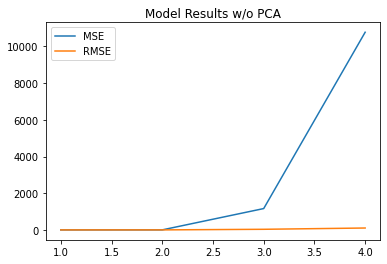

MSEs: [0.12477619208575627, 2.208283651104672, 1164.0427931771655, 10773.871254421896]
RMSEs: [0.3532367366027439, 1.4860294920036654, 34.11807135781807, 103.79726034160004]

1's top 3 weights were [7.0400972  3.55797652 2.43617098]
at [ 4 16 19]
2's top 3 weights were [2.80228762e-10 1.73346824e-10 1.50589498e-10]
at [294 138 139]
3's top 3 weights were [1.77036029e-21 1.41775452e-21 1.11350792e-21]
at [ 670 2130 1246]
4's top 3 weights were [2.47659165e-33 1.95346347e-33 1.78351157e-33]
at [ 3266 21924  3267]


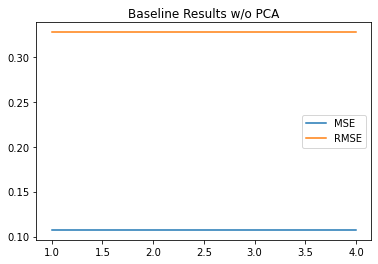

MSEs: [0.1073437991575987, 0.1073437991575987, 0.1073437991575987, 0.1073437991575987]
RMSEs: [0.3276336355711951, 0.3276336355711951, 0.3276336355711951, 0.3276336355711951]



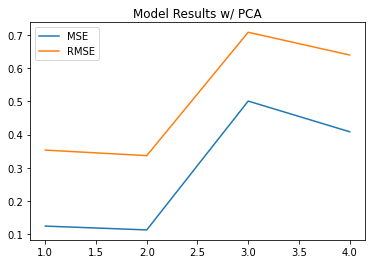

MSEs: [0.12478314933910459, 0.11331777439035845, 0.5006301109707497, 0.40839830480828043]
RMSEs: [0.35324658432758355, 0.33662705534516746, 0.7075521966404668, 0.639060486032645]

1's top 3 weights were [0.83603456 0.27485375 0.19681704]
at [20 23 15]
2's top 3 weights were [0.1871602  0.15311082 0.15001184]
at [208 177 191]
3's top 3 weights were [0.05586396 0.04949799 0.03754738]
at [2245  464  378]
4's top 3 weights were [0.01112554 0.01018534 0.0099472 ]
at [2943 3057 2932]


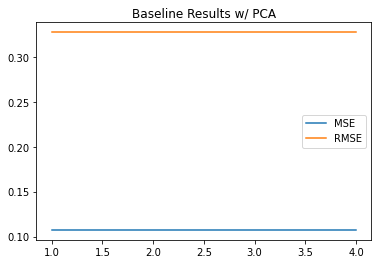

MSEs: [0.1073437991575987, 0.1073437991575987, 0.1073437991575987, 0.1073437991575987]
RMSEs: [0.3276336355711951, 0.3276336355711951, 0.3276336355711951, 0.3276336355711951]



In [ ]:
def plotResults(results, title):
    plt.title(title)
    plt.plot(results['x'], results['mse'], label = "MSE")
    plt.plot(results['x'], results['rmse'], label = "RMSE")
    plt.legend()
    plt.show()
    print("MSEs: {}".format(results['mse']))
    print("RMSEs: {}".format(results['rmse']))
    print()
    for x, clf in zip(results['x'], results['clf']):
        coef = clf.coef_.ravel()
        max_3_idx = coef.argsort()[-3:][::-1]
        print("{}'s top 3 weights were {}".format(x, coef[max_3_idx]))
        print("at {}".format(max_3_idx))

plotResults(trueBaseResults, "Model Results w/o PCA")
plotResults(baselineBaseResults, "Baseline Results w/o PCA")
plotResults(truePcResults, "Model Results w/ PCA")
plotResults(baselinePcResults,"Baseline Results w/ PCA")


## Train Neural Net Model

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

def trainAndGetResultsNN(X, baseline=False):
    results = {'clf': [] , 'x': [], 'X_train': [], 'Y_pred': [], 'Y_test': [], 'mse': [], 'rmse': []}
    for i in range(1, 2):
        if not baseline:
            print("X Shape = ")
            print(X.shape)
            
            # poly_features = X
            poly = PolynomialFeatures(degree=1)
            poly_features = poly.fit_transform(X)
            
            X_train, X_test, Y_train, Y_test = train_test_split(poly_features, Y, test_size=0.33, random_state=42)

            learning_rate_init = 0.001 / (1 * 30.0) # 30 yields best results
            epsilon = 1 * 10 ** -(2) # 1e-2 yields best results
            # epsilon = 1e-8
            clf = MLPRegressor(random_state=1, max_iter=50000, learning_rate_init=learning_rate_init, epsilon=epsilon)
            clf.fit(X_train, Y_train.values.ravel()) # Y_train.values.ravel()
            Y_pred = clf.predict(X_test)
            
    
            results['clf'].append(clf)
            results['X_train'].append(X_train)
            results['Y_pred'].append(Y_pred)
            results['Y_test'].append(Y_test)

            mse = mean_squared_error(Y_test, Y_pred)
            rmse = mean_squared_error(Y_test, Y_pred, squared=False)
        else:
            mse = mean_squared_error(Y, Y_baseline)
            rmse = mean_squared_error(Y, Y_baseline, squared=False)

        results['x'].append(i)
        results['mse'].append(mse)
        results['rmse'].append(rmse)
    return results

trueBaseResultsNN = trainAndGetResultsNN(X)
baselineBaseResultsNN = trainAndGetResultsNN(X, baseline=True)
truePcResultsNN = trainAndGetResultsNN(X_pc)
baselinePcResultsNN = trainAndGetResultsNN(X_pc, baseline=True)

X Shape = 
(100, 24)
X Shape = 
(100, 20)


## Plot Neural Net Model

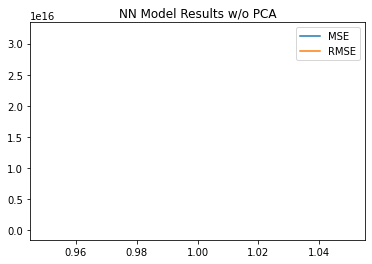

MSEs: [3.1834571638308996e+16]
RMSEs: [178422452.73033604]



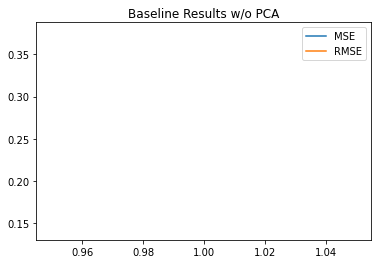

MSEs: [0.14167585770577254]
RMSEs: [0.37639853573808246]



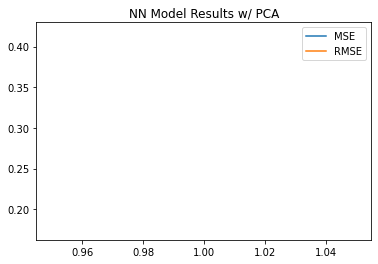

MSEs: [0.17449974337328006]
RMSEs: [0.41773166431727443]



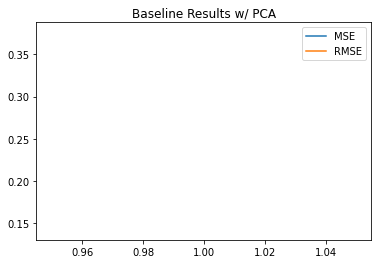

MSEs: [0.14167585770577254]
RMSEs: [0.37639853573808246]



In [ ]:
def plotResultsNN(results, title):
    plt.title(title)
    plt.plot(results['x'], results['mse'], label = "MSE")
    plt.plot(results['x'], results['rmse'], label = "RMSE")
    plt.legend()
    plt.show()
    print("MSEs: {}".format(results['mse']))
    print("RMSEs: {}".format(results['rmse']))
    print()
    """for x, clf in zip(results['x'], results['clf']):
        coef = clf.coef_.ravel()
        max_3_idx = coef.argsort()[-3:][::-1]
        print("{}'s top 3 weights were {}".format(x, coef[max_3_idx]))
        print("at {}".format(max_3_idx))"""

plotResultsNN(trueBaseResultsNN, "NN Model Results w/o PCA")
plotResultsNN(baselineBaseResultsNN, "Baseline Results w/o PCA")
plotResultsNN(truePcResultsNN, "NN Model Results w/ PCA")
plotResultsNN(baselinePcResultsNN,"Baseline Results w/ PCA")

## Real-World Results

In [ ]:
# Collect data from 10 different stocks
final_tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']
final_pca = PCA(n_components=21)
final_poly = PolynomialFeatures(degree=1)

spy_X = api.getSamplesFromTickers(final_tickers, samplesPerTicker=50, maxTickers=10)
spy_Y = api.getYFromDF(spy_X)

Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request.

In [ ]:
print(api.getNumApiCalls())

59


In [ ]:
spy_merged = pd.merge(spy_X, spy_Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()
spy_X = spy_merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage'], axis=1)
spy_Y = spy_merged[['percentage']]

spy_X_scaled = pd.DataFrame(ss.fit_transform(spy_X), columns = spy_X.columns)
spy_X_pc = final_pca.fit_transform(spy_X_scaled)
spy_X_poly = final_poly.fit_transform(spy_X_scaled)
spy_X_pc_poly = final_poly.fit_transform(spy_X_pc)

In [ ]:
display(spy_X.head())

print(spy_X.shape)
print(spy_Y.shape)

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceEarningsToGrowthRatio,priceToOperatingCashFlowsRatio,growthRevenue,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,2.417060,1.183192,0.463331,0.140986,0.044320,0.086332,0.106114,0.947941,3.578668,3.694332,10.363047,-0.663154,22.509203,-0.046434,0.006513,-0.091210,-0.046956,-0.060347,-0.156080,-0.183012,-0.128904,-0.156269,6.881063e+09,6.396663e+09
1,2.486968,1.256414,0.406252,0.085668,0.024809,0.048508,0.056355,0.955253,2.715416,3.145034,13.994552,0.581428,-117.575442,0.149466,0.261380,0.026313,-0.107139,-0.028530,0.084785,0.197414,0.224753,0.240693,6.207983e+09,5.707283e+09
2,2.408181,1.159514,0.425086,0.120382,0.035888,0.070659,0.081439,0.968898,3.150645,3.595607,11.147385,-6.150476,91.272752,0.014103,0.001648,0.028171,0.013873,0.053745,-0.008826,-0.044202,-0.025167,-0.018124,7.192293e+09,6.798493e+09
3,2.603645,1.311136,0.469580,0.122611,0.034282,0.064734,0.078216,0.888309,3.427961,4.169088,13.238629,-0.094061,22.266278,-0.043250,0.002847,-0.086424,-0.045126,0.319706,-1.151828,-1.475884,-1.405034,-1.407446,7.154155e+09,6.523655e+09
4,3.818182,2.303242,0.855642,0.349526,0.076997,0.092569,0.130432,0.202237,8.581899,22.997420,23.177087,1.202891,71.048443,0.102355,0.209235,0.086158,-0.014693,0.115837,0.006301,0.045876,0.040462,0.192678,1.335000e+10,1.286310e+10


(101, 24)
(101, 1)


In [ ]:
# print(truePcResults['clf'][0])
print(spy_X_poly.shape)
print(spy_X_pc_poly.shape)

(101, 25)
(101, 22)


In [ ]:
r1 = trueBaseResults['clf'][0].predict(spy_X_poly)
r2 = truePcResults['clf'][0].predict(spy_X_pc_poly)

r1MSE = mean_squared_error(spy_Y, r1)
r2MSE = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE)
print(r2MSE)
print(baseMSE)

ValueError: ignored

In [ ]:
r1 = trueBaseResultsNN['clf'][0].predict(spy_X_poly)
# r2 = truePcResultsNN['clf'][0].predict(spy_X_pc_poly)
r2 = truePcResultsNN['clf'][-1].predict(spy_X_pc_poly)

r1MSE_NN = mean_squared_error(spy_Y, r1)
r2MSE_NN = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE_NN)
print(r2MSE_NN)
print(baseMSE)